Link to tutorial: https://keras.io/examples/timeseries/timeseries_anomaly_detection/

In [1]:
# importing libraries
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [2]:
# importing the dataset
# link to dataset: https://github.com/numenta/NAB
# dataset license: https://github.com/numenta/NAB/blob/master/LICENSE.txt

dataset_url = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# for this tutorial two datasets be utilized
# training dataset: art_daily_small_noise.csv 
# test dataset: art_daily_jumpsup.csv

# link to training data
small_noise_daily_data = dataset_url + "artificialNoAnomaly/art_daily_small_noise.csv"
# link to test data
daily_jumpsup_data = dataset_url + "artificialWithAnomaly/art_daily_jumpsup.csv"

# reading in the datasets into dataframes
df_small_noise = pd.read_csv(small_noise_daily_data, parse_dates=True, index_col="timestamp")
df_jumpsup = pd.read_csv(daily_jumpsup_data, parse_dates=True, index_col="timestamp")

In [3]:
# reading the training dataset
df_small_noise

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
...,...
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127


In [4]:
# reading the test dataset
df_jumpsup

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


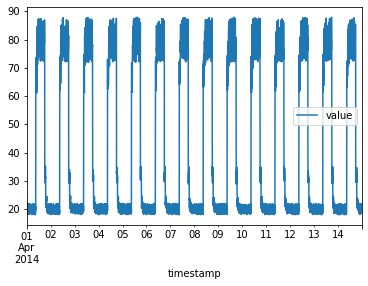

In [5]:
# visualizing the training dataset
df_small_noise.plot()

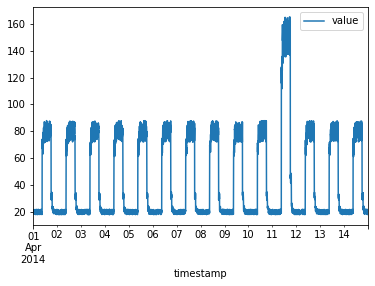

In [7]:
# visualizing the test dataset
df_jumpsup.plot()

In [8]:
# pre-processing the training dataset for model development
# there is a data point for every 5 minute interval over 14 day period.
# 24*(60/5) = 288 data points per day (timesteps)
# total number of data points: 288 * 14  = 4032 

# normalizing the training dataset
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
normalized_training_data = (df_small_noise - training_mean) / training_std
print("Number of training data points:", len(normalized_training_data))

Number of training data points: 4032


In [10]:
# combining timesteps from the training data to create a sequence 

Time_steps = 288

# function to generate a training sequence for model input
def create_sequences(values, time_steps=Time_steps):
  output = []
  for i in range(len(values) - time_steps + 1):
    output.append(values[i : (i + time_steps)])
  return np.stack(output)

x_train = create_sequences(normalized_training_data.values)
print("Training input shape:", x_train.shape)

Training input shape: (3745, 288, 1)


In [11]:
# building a convolutional reconstruction autoencoder model
# model input is of shape (batch size, sequence length, number of features) 
# model output is the same shape as model input  

In [13]:
model = keras.Sequential(
    [
      layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
      layers.Conv1D(
          filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
      ),
      layers.Dropout(rate=0.2),
      layers.Conv1D(
         filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
      ),
      layers.Conv1DTranspose(
         filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
      ),
      layers.Dropout(rate=0.2),
      layers.Conv1DTranspose(
         filters=32, kernel_size=7, padding="same", strides=2, activation="relu"         
      ),
      layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [14]:
#model training 
# using x_train as model input & model target since it is a reconstruction model

history = model.fit(
    x_train,
    x_train,
    epochs = 50,
    batch_size = 128,
    validation_split = 0.1,
    callbacks = [
                 keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
    ], 
)

Epoch 1/50
27/27 [==============================] - 6s 135ms/step - loss: 0.6872 - val_loss: 0.1851
Epoch 2/50
27/27 [==============================] - 3s 115ms/step - loss: 0.0982 - val_loss: 0.0467
Epoch 3/50
27/27 [==============================] - 3s 115ms/step - loss: 0.0579 - val_loss: 0.0366
Epoch 4/50
27/27 [==============================] - 3s 116ms/step - loss: 0.0492 - val_loss: 0.0302
Epoch 5/50
27/27 [==============================] - 3s 116ms/step - loss: 0.0425 - val_loss: 0.0278
Epoch 6/50
27/27 [==============================] - 3s 118ms/step - loss: 0.0368 - val_loss: 0.0261
Epoch 7/50
27/27 [==============================] - 3s 122ms/step - loss: 0.0327 - val_loss: 0.0257
Epoch 8/50
27/27 [==============================] - 3s 115ms/step - loss: 0.0299 - val_loss: 0.0261
Epoch 9/50
27/27 [==============================] - 3s 120ms/step - loss: 0.0275 - val_loss: 0.0234
Epoch 10/50
27/27 [==============================] - 3s 115ms/step - loss: 0.0257 - val_loss: 0.0228

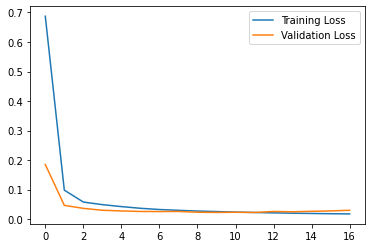

In [19]:
# Plotting model training data
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label ="Validation Loss") 
plt.legend()

Reconstruction error threshold:  0.13714298145615997


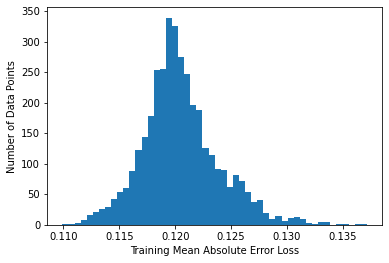

In [20]:
# to detect anomalies, compare the model output with input data
# detect anomalies based on the model reconstructing the input data values
# find the mean absolute error from training data
x_train_prediction = model.predict(x_train)
train_max_absolute_error_loss = np.mean(np.abs(x_train_prediction - x_train), axis=1)

# plotting the data using a histogram
plt.hist(train_max_absolute_error_loss, bins=50)
plt.xlabel("Training Mean Absolute Error Loss")
plt.ylabel("Number of Data Points")
# find the max mean absolute error value
# max mean absolute error value is the worst model performance when reconstructing a training data
# max mean absolute error value will be the threshold for anomaly detection
# if the reconstruction loss for a data point is greater than the threshold value, treat it as an outlier
anomaly_detection_threshold = np.max(train_max_absolute_error_loss)
print("Reconstruction error threshold: ", anomaly_detection_threshold)


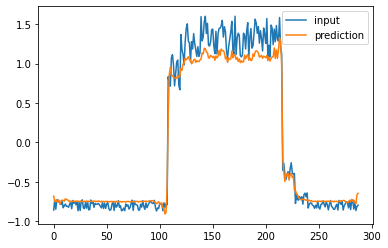

In [26]:
# comparing reconstruction for the first day of data points
plt.plot(x_train[0], label= "input")
plt.plot(x_train_prediction[0], label = "prediction")
plt.legend()

In [27]:
#pre-processing test dataset to evaluate model performance

# normalizing the test dataset
test_mean = df_jumpsup.mean()
test_std = df_jumpsup.std()
normalized_test_data = (df_jumpsup - test_mean) / test_std
print("Number of test data points:", len(normalized_test_data))

Number of test data points: 4032


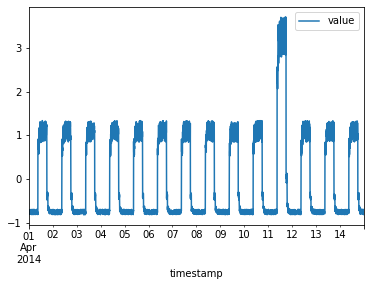

In [28]:
# plotting normalized data
normalized_test_data.plot()

In [29]:
# creating a sequence from test data so it can be input into the model for prediction
x_test = create_sequences(normalized_test_data.values)
print("Test data input shape: ", x_test.shape)

Test data input shape:  (3745, 288, 1)


In [30]:
# finding the test data mean absolute error loss 
x_test_prediction = model.predict(x_test)
test_mean_absolute_error_loss = np.mean(np.abs(x_test_prediction - x_test), axis=1)
test_mean_absolute_error_loss = test_mean_absolute_error_loss.reshape((-1))

Text(0, 0.5, 'Number of test data points')

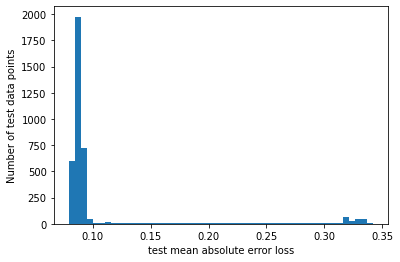

In [31]:
# plotting the loss from the test set using a histogram
plt.hist(test_mean_absolute_error_loss, bins=50)
plt.xlabel("test mean absolute error loss")
plt.ylabel("Number of test data points")


In [33]:
# anomaly detection for the test set based on anomaly detection threshold
anomalies = test_mean_absolute_error_loss > anomaly_detection_threshold
print("Number of anomaly samples ", np.sum(anomalies))
print("Indices of anomalies: ", np.where(anomalies))

Number of anomaly samples  348
Indices of anomalies:  (array([2726, 2727, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737,
       2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748,
       2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
       2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770,
       2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781,
       2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792,
       2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803,
       2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814,
       2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825,
       2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836,
       2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847,
       2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858,
       2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 28

In [36]:
# plot the predicted anomalies on the original dataset
anomaly_indices = []
for data_idx in range(Time_steps - 1, len(normalized_test_data) - Time_steps + 1):
  if np.all(anomalies[data_idx - Time_steps + 1 : data_idx]):
    anomaly_indices.append(data_idx)

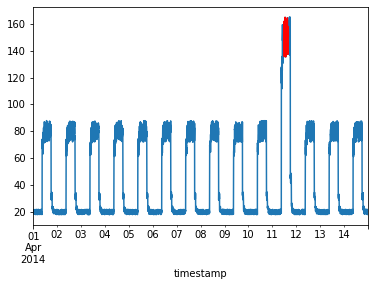

In [39]:
# create the plot
df_subset = df_jumpsup.iloc[anomaly_indices]
fig, ax = plt.subplots()
df_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")